<center><i>Łukasz Staniszewski, Łukasz Topolski</i></center>
<h1><center>Mini projekt 3 - SSNE - Klasyfikator Obrazów</center></h1>

# I. Zadanie
+ Zadanie polega na stworzeniu klasyfikatora obrazków działającego na 50 klasach z różnymi przedmiotami/zwierzętami itp.
+ Do dyspozycji jest zbiór treningowy podzielony na odpowiednie podfoldery z klasami oraz zbiór testowy - bez podziału. Zbiór treningowy jest przygotowany w taki sposób by można go było łatwo załadować za pomocą klasy torchvision.ImageFolder wywołując np: ```trainset = ImageFolder("data/train/", transform=train_transform)```

    + Wówczas wszystkie przykłady zostaną przypisane do odpowiedniej klasy w zależności od tego w jakim podfolderze się znajdowały.

+ W ramach predykcji proszę zapisać tym razem dwie kolumny (bez nagłówków):
    + Pierwszą kolumnę z nazwami plików testowych (uwaga - pliki nazywają się np. 850043533599308.JPEG).
    + Drugą kolumnę z wartościami, oznaczającą predykcję numeru klasy. Klasy ponumerowane są zgodnie z numeracją ze zbioru treningowego (startując od zera). Można to sprawdzić wywołując ```trainset.classes```.

+ Końcowe wyniki obliczane będą w oparciu o średnie accuracy na wszystkich klasach.

# II. Rozwiązanie

## IMPORT, SEED, CUDA
+ Import:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as Functional
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

+ GPU:

In [2]:
torch.cuda.set_device(0)
device = torch.device("cuda")
torch.cuda.is_available()

True

+ Seedy:

In [3]:
if torch.cuda.is_available():
    torch.cuda.manual_seed(500)
    torch.cuda.manual_seed_all(500)

torch.manual_seed(500)

torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False


## "ZABAWA" Z DANYMI
+ Datasety + dodatkowe data augmentation:

In [4]:
transform_orig = transforms.Compose(
    [transforms.ToTensor()]
)

transform_aug = transforms.Compose(
    [transforms.RandomHorizontalFlip(0.5),
     transforms.RandomVerticalFlip(0.5),
     transforms.RandomRotation(25),
     transforms.ToTensor(),
     transforms.RandomErasing(0.5),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
dataset_no_aug = torchvision.datasets.ImageFolder("data/train/", transform=transform_orig)
dataset_aug = torchvision.datasets.ImageFolder("data/train/", transform=transform_aug)
dataset = torch.utils.data.ConcatDataset([dataset_no_aug, dataset_aug])

+ Rozdzielenie między trenującym a walidacyjnym:

In [6]:
VALIDATION_SET_RATIO = 0.2
dataset_indices = list(range(len(dataset)))
np.random.shuffle(dataset_indices)
valid_split_index = int(np.floor(VALIDATION_SET_RATIO * len(dataset)))

train_idx, val_idx = dataset_indices[valid_split_index:], dataset_indices[:valid_split_index]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(val_idx)

+ Data loading:

In [7]:
BATCH_SIZE = 128
# no shuffle - using it in sampler
train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, sampler=valid_sampler)

+ Przykładowe obrazki:

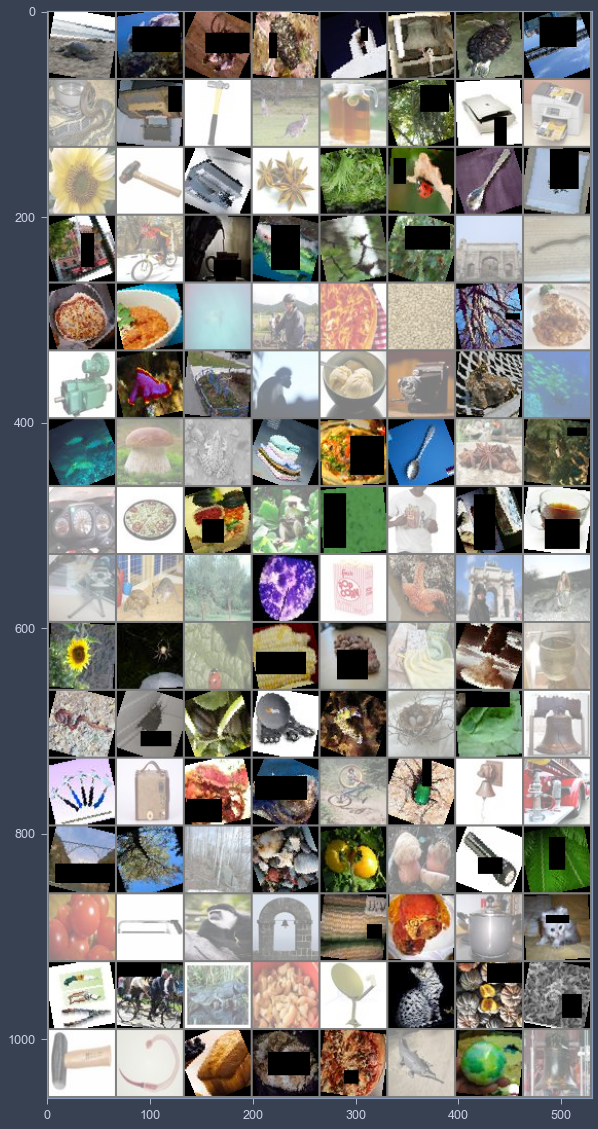

In [8]:
plt.figure(figsize=(10, 20))


def imshow(img):
    img = img / 2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

+ Klasy:

In [9]:
dataset_no_aug.class_to_idx

{'acoustic': 0,
 'antenna': 1,
 'bacteria': 2,
 'battery': 3,
 'bean': 4,
 'beetle': 5,
 'bicycle': 6,
 'birch': 7,
 'bird': 8,
 'bomb': 9,
 'bread': 10,
 'bridge': 11,
 'camera': 12,
 'carbon': 13,
 'cat': 14,
 'corn': 15,
 'crab': 16,
 'crocodilian': 17,
 'echinoderm': 18,
 'egg': 19,
 'elephant': 20,
 'fish': 21,
 'flower': 22,
 'frog': 23,
 'fungus': 24,
 'gauge': 25,
 'hammer': 26,
 'icecream': 27,
 'kangaroo': 28,
 'memorial': 29,
 'monkey': 30,
 'motor': 31,
 'nest': 32,
 'palm': 33,
 'pizza': 34,
 'pot': 35,
 'printer': 36,
 'saw': 37,
 'snake': 38,
 'spice': 39,
 'spider': 40,
 'spoon': 41,
 'squash': 42,
 'swine': 43,
 'tea': 44,
 'tomato': 45,
 'towel': 46,
 'truck': 47,
 'turtle': 48,
 'worm': 49}

## Konwolucyjna sieć neuronowa
+ Zdefiniowanie podstawowych elementów.

In [10]:
next(iter(train_loader))[0].shape

torch.Size([128, 3, 64, 64])

In [11]:
class ImageNet(nn.Module):
    def __init__(self):
        super().__init__()
        # we: 64x64
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=80, kernel_size=(3,3))
        self.bn1 = nn.BatchNorm2d(80)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=(2, 2))

        #
        self.conv2 = nn.Conv2d(in_channels=80, out_channels=100, kernel_size=(2,2))
        self.bn2 = nn.BatchNorm2d(100)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        #
        self.conv3 = nn.Conv2d(in_channels=100, out_channels=120, kernel_size=(1,1))
        self.bn3 = nn.BatchNorm2d(120)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        #
        self.conv4 = nn.Conv2d(in_channels=120, out_channels=140, kernel_size=(2,2))
        self.bn4 = nn.BatchNorm2d(140)

        #
        self.conv5 = nn.Conv2d(in_channels=140, out_channels=200, kernel_size=(3,3))
        self.bn5 = nn.BatchNorm2d(200)

        #
        self.conv6 = nn.Conv2d(in_channels=200, out_channels=250, kernel_size=(2,2))
        self.bn6 = nn.BatchNorm2d(250)
        # 6 x 6

        self.fc1 = nn.Linear(5*5*250, 3500)
        self.fc2 = nn.Linear(3500, 1100)
        self.fc3 = nn.Linear(1100, 300)
        self.fc4 = nn.Linear(300, 50)

    def forward(self, x):
        x=self.bn1(Functional.relu(self.conv1(x)))
        x=self.bn2(Functional.relu(self.conv2(x)))
        x=self.pool1(x)

        x=self.bn3(Functional.relu(self.conv3(x)))
        x=self.bn4(Functional.relu(self.conv4(x)))
        x=self.pool2(x)

        x=self.bn5(Functional.relu(self.conv5(x)))
        x=self.bn6(Functional.relu(self.conv6(x)))
        x=self.pool3(x)
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = Functional.relu(self.fc1(x))
        x = Functional.relu(self.fc2(x))
        x = Functional.relu(self.fc3(x))
        x = self.fc4(x)

        return x


net = ImageNet().to(device)
net

ImageNet(
  (conv1): Conv2d(3, 80, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(80, 100, kernel_size=(2, 2), stride=(1, 1))
  (bn2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(100, 120, kernel_size=(1, 1), stride=(1, 1))
  (bn3): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(120, 140, kernel_size=(2, 2), stride=(1, 1))
  (bn4): BatchNorm2d(140, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(140, 200, kernel_size=(3, 3), stride=(1, 1))
  (bn5): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

+ Uczenie:

In [26]:
N_EPOCHS = 40
for epoch in range(N_EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print("[{}/{}] loss: {}".format(epoch+1, N_EPOCHS, running_loss / len(train_loader)))
    running_loss = 0.0

print('Finished Training')

[1/40] loss: 2.9089454338834244
[2/40] loss: 2.3381846294307795
[3/40] loss: 2.0051341319928704
[4/40] loss: 1.753219543534122
[5/40] loss: 1.5273583436640255
[6/40] loss: 1.3350697237182811
[7/40] loss: 1.1744916327534536
[8/40] loss: 1.0509131922167503
[9/40] loss: 0.963471184255425
[10/40] loss: 0.9114175351720631
[11/40] loss: 0.8661217564187409
[12/40] loss: 0.835714242357649
[13/40] loss: 0.796066171791638
[14/40] loss: 0.7743124375821893
[15/40] loss: 0.7684490124438699
[16/40] loss: 0.7321565379401319
[17/40] loss: 0.711997486996066
[18/40] loss: 0.691850995795495
[19/40] loss: 0.6785292252695203
[20/40] loss: 0.6568095818581525
[21/40] loss: 0.6458477250399317
[22/40] loss: 0.6254337763212465
[23/40] loss: 0.6170092704185673
[24/40] loss: 0.6342835014890693
[25/40] loss: 0.5895967113765991
[26/40] loss: 0.5744531815643207
[27/40] loss: 0.556270554675285
[28/40] loss: 0.5478667606016813
[29/40] loss: 0.5432183339745212
[30/40] loss: 0.5299578847449872
[31/40] loss: 0.5146756725

KeyboardInterrupt: 

+ Wyniki:

In [28]:
def get_results_accuracy(loader, b_size):
    correct = 0
    total = 0
    all_outs = []
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device)
            outputs = net(images).cpu()
            _, predicted = torch.max(outputs.data, 1)
            all_outs.extend(predicted.tolist())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print('Accuracy of the network on the {} test images: {}'.format(len(loader)*b_size, acc))
    return acc, all_outs

+ Accuracy na treningowym i walidacyjnym:

In [29]:
acc_training, all_outs_training = get_results_accuracy(train_loader, BATCH_SIZE)
acc_valid, all_outs_valid = get_results_accuracy(valid_loader, BATCH_SIZE)

Accuracy of the network on the 140928 test images: 90.22923205840162
Accuracy of the network on the 35328 test images: 69.36143620043177


In [30]:
all_class_names = dataset_no_aug.classes
correct_predicts_by_class = {name_class: 0 for name_class in all_class_names}
predicts_by_class = {name_class: 0 for name_class in all_class_names}

with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        images = images.to(device)
        outputs = net(images).cpu()
        _, predicted = torch.max(outputs, 1)

        for label, model_prediction in zip(labels, predicted):
            if label == model_prediction:
                correct_predicts_by_class[all_class_names[label]] += 1
            predicts_by_class[all_class_names[label]] += 1


# print accuracy for each class
for name_class, count_ok in correct_predicts_by_class.items():
    acc = 100 * count_ok / predicts_by_class[name_class]
    print("Accuracy for {} = {:.2f}%".format(name_class, acc))

Accuracy for acoustic = 52.89%
Accuracy for antenna = 63.48%
Accuracy for bacteria = 73.04%
Accuracy for battery = 64.11%
Accuracy for bean = 73.78%
Accuracy for beetle = 76.80%
Accuracy for bicycle = 72.43%
Accuracy for birch = 65.05%
Accuracy for bird = 56.40%
Accuracy for bomb = 70.98%
Accuracy for bread = 61.92%
Accuracy for bridge = 79.03%
Accuracy for camera = 76.44%
Accuracy for carbon = 50.74%
Accuracy for cat = 62.43%
Accuracy for corn = 65.03%
Accuracy for crab = 57.95%
Accuracy for crocodilian = 64.76%
Accuracy for echinoderm = 61.41%
Accuracy for egg = 66.94%
Accuracy for elephant = 71.49%
Accuracy for fish = 68.49%
Accuracy for flower = 88.56%
Accuracy for frog = 57.51%
Accuracy for fungus = 71.16%
Accuracy for gauge = 62.24%
Accuracy for hammer = 85.23%
Accuracy for icecream = 65.87%
Accuracy for kangaroo = 65.97%
Accuracy for memorial = 80.50%
Accuracy for monkey = 75.28%
Accuracy for motor = 65.75%
Accuracy for nest = 55.75%
Accuracy for palm = 82.30%
Accuracy for pizza

+ Średnie accuracy na wszystkich klasach:

In [ ]:
sum_percents = 0
for name_class, count_ok in correct_predicts_by_class.items():
    sum_percents += 100 * count_ok / predicts_by_class[name_class]
print("FINAL CLASS AVERAGE: {:.2f}".format(sum_percents/50))

FINAL CLASS AVERAGE: 68.05


+ Predykowane klasy na walidacyjnym w postaci histogramu:

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

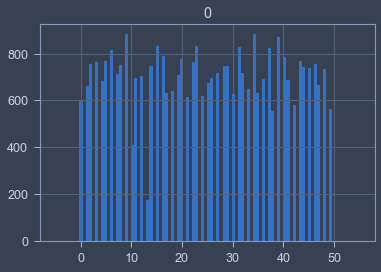

In [ ]:
import pandas as pd
pd.DataFrame(all_outs_valid).hist(bins=100, range=(-5,55))

## ZAPISANIE MODELU DO PLIKU I WCZYTANIE


+ Zapisanie:

In [19]:
state_dict = net.state_dict()

In [20]:
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%Y_%m_%d_%H_%M_%S")

file_name = f"model_{int(acc_valid)}acc_{dt_string}.tar"
torch.save(state_dict, file_name)


+ Wczytanie:

In [27]:
def load_model(model_name):
    state_dict = torch.load(model_name)
    net = ImageNet()
    net.load_state_dict(state_dict)
    net.to(device)
    return net

load_model("model_68acc_2021_12_01_22_47_19.tar")

ImageNet(
  (conv1): Conv2d(3, 80, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(80, 100, kernel_size=(2, 2), stride=(1, 1))
  (bn2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(100, 120, kernel_size=(1, 1), stride=(1, 1))
  (bn3): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(120, 140, kernel_size=(2, 2), stride=(1, 1))
  (bn4): BatchNorm2d(140, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(140, 200, kernel_size=(3, 3), stride=(1, 1))
  (bn5): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine

## ZAPISANIE WYNIKÓW DLA ZBIORU TESTOWEGO

In [22]:
eval_dataset = torchvision.datasets.ImageFolder("data/test/", transform=transform_orig)

In [23]:
preds_list_eval = []
net.eval()
with torch.no_grad():
    for index_x, x in enumerate(eval_dataset):
        x = x[0].to(device).unsqueeze(0)
        predicted_val = net(x).cpu()
        _, predicted = torch.max(predicted_val.data, 1)
        ret = (eval_dataset.imgs[index_x][0].lstrip(r"data/test/test_all\\"), predicted.item())
        preds_list_eval.append(ret)

df_out = pd.DataFrame(preds_list_eval)
df_out

,0,1
0,00013066837824360356.JPEG,26
1,00022240850406751722.JPEG,31
2,0004927347689911432.JPEG,2
3,000563265767796084.JPEG,39
4,0006013938786831874.JPEG,45
...,...,...
9995,9996231273861222.JPEG,12
9996,9996908958438282.JPEG,25
9997,9997674427283424.JPEG,31
9998,9997698258014044.JPEG,8


In [24]:
csv = df_out.to_csv(index=False, header=False)
with open('result.csv', 'w', newline="") as f:
    f.write(csv)

+ Przykładowe predykcje:

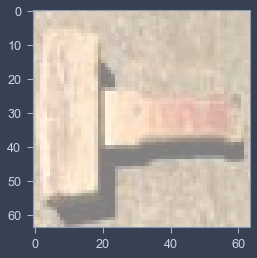

hammer


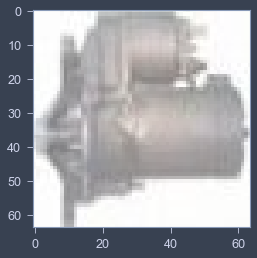

motor


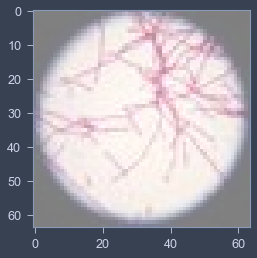

bacteria


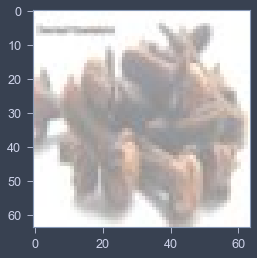

spice


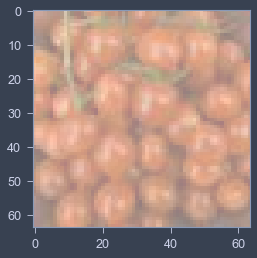

tomato


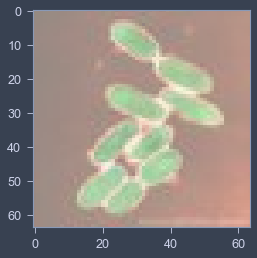

bacteria


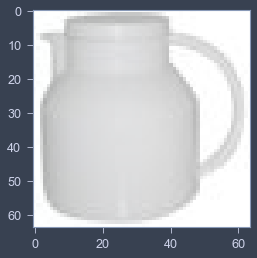

antenna


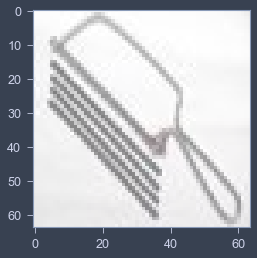

saw


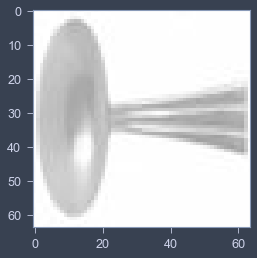

spoon


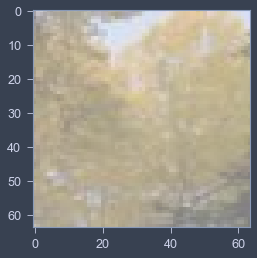

birch


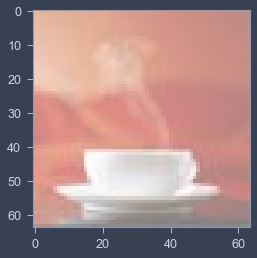

tea


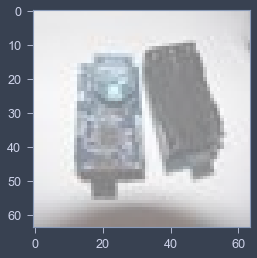

camera


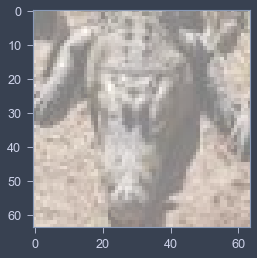

swine


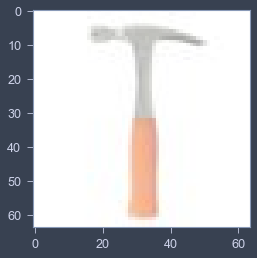

hammer


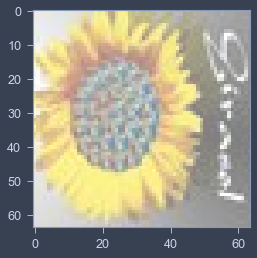

flower


In [25]:
for i in range(15):
    imshow(eval_dataset[i][0])
    print(all_class_names[preds_list_eval[i][1]])